[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Guetguet6/PenguinVsTurtle/blob/collabory/Untitled0.ipynb)

In [1]:
import torch
import torchvision
import pandas as pd
from torch.utils.data import DataLoader
from skimage import io
import os
from pandas import DataFrame

In [ ]:
!wget https://drive.google.com -o archive.zip
!unzip -q archive.zip -d /content/data
!mv /content/data/train_annotations /content/data/train_annotations.json
!mv /content/data/valid_annotations /content/data/valid_annotations.json

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [25]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir: str, json_file: str, split: str='train', transform: torchvision.transforms = None):
        self.root_dir:str = os.path.join(root_dir, split, split)
        self.annotations:DataFrame = pd.read_json(os.path.join(root_dir, json_file))
        self.transform:torchvision.transforms = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        image_id = self.annotations.iloc[index]["image_id"]
        img_path = os.path.join(self.root_dir, f'image_id_{image_id:03d}.jpg')
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index]['category_id']))
        

        if self.transform:
            image = self.transform(image)

        return [image, y_label]

In [26]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean=0.5, std=0.5)])

In [27]:
train_dataset = CustomDataset(root_dir='', split="train", json_file='train_annotations.json', transform=transform)
valid_dataset = CustomDataset(root_dir='', split="valid", json_file='valid_annotations.json', transform=transform)

In [28]:
print('Number of training examples: ', len(train_dataset))
print('Number of validation examples: ', len(valid_dataset))

Number of training examples:  500
Number of validation examples:  72


In [29]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

In [31]:
examples = enumerate(valid_loader)
batch_idx, data = next(examples)
print(len(data))

2


In [33]:
print('Images:', data[0].shape)
b, c, h, w = data[0].shape
print('Batch(s):', b) # 32 images traitées à la fois
print('Channel(s):', c) # 1 seul canal de couleur car c'est une image en noir et blanc (3 canaux si c'était une image RGB)
print('Height:', h) # 28 pixels de hauteur
print('Width:', w) # 28 pixels de largeur
print('Labels:', data[1].shape) # 32 labels
print(data[1])

Images: torch.Size([32, 3, 640, 640])
Batch(s): 32
Channel(s): 3
Height: 640
Width: 640
Labels: torch.Size([32])
tensor([1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1,
        1, 1, 2, 2, 1, 1, 2, 2])


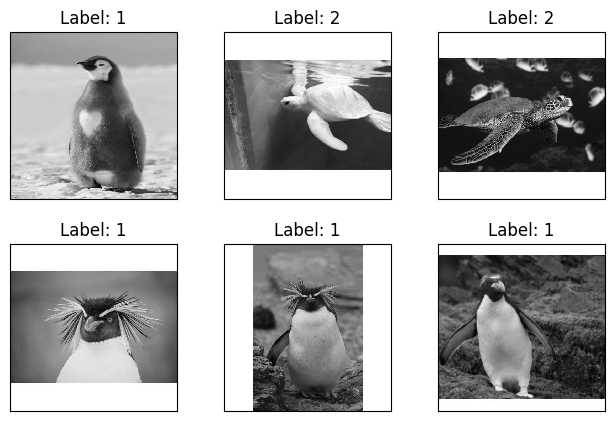

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(data[0][i][0], cmap='gray', interpolation='none')
    plt.title(f'Label: {data[1][i]}')
    plt.xticks([])
    plt.yticks([])

In [35]:
from TP5_MHA import MultiHeadAttention

In [36]:
class VisionEncoder(torch.nn.Module):
    def __init__(self, embed_size, num_heads, hidden_size, dropout):
        super(VisionEncoder, self).__init__()

        self.embed_size = embed_size
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.dropout = dropout

        # Première couche : Linear + LayerNorm
        self.norm1 = torch.nn.LayerNorm(embed_size)
        self.mha = MultiHeadAttention(embed_size, num_heads, dropout)
        self.add_norm = torch.nn.Sequential(
            torch.nn.Linear(embed_size, hidden_size),
            torch.nn.GELU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_size, embed_size),
            torch.nn.Dropout(dropout)
        )

    def forward(self, x):
        # Première couche : Normalisation + Multi-Head Attention + Résiduel
        norm1_output = self.norm1(x)
        mha_output = self.mha(norm1_output, norm1_output, norm1_output)
        add_norm1_output = x + mha_output

        # Deuxième couche : Linear + GELU + Dropout + Linear + Dropout + Résiduel
        mlp_output = self.add_norm(add_norm1_output)
        add_norm2_output = add_norm1_output + mlp_output

        return add_norm2_output

In [37]:
import torch.nn as nn
import torch
import torch.nn as nn

class ViT(nn.Module):
    def __init__(self, image_size, channel_size, patch_size, embed_size, nb_heads, classes, nb_layers, hidden_size, dropout):
        super(ViT, self).__init__()

        # Paramètres
        self.image_size = image_size
        self.channel_size = channel_size
        self.pixels = image_size ** 2 * channel_size

        self.patch_size = patch_size
        self.embed_size = embed_size
        self.nb_patches = (image_size // patch_size) ** 2
        self.pixels_per_patch = channel_size * (patch_size ** 2)
        self.nb_heads = nb_heads
        self.classes = classes
        self.nb_layers = nb_layers
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.dropout_layer = torch.nn.Dropout(p=dropout)

        # Projection linéaire
        self.embeddings = nn.Linear(self.pixels_per_patch, self.embed_size)

        # Class token
        self.class_token = nn.Parameter(torch.randn(1,1,embed_size))

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1,self.nb_patches+1,embed_size))

        # Layers d'encodage
        self.encoders = nn.ModuleList([
            VisionEncoder(embed_size, nb_heads, hidden_size, dropout)
            for _ in range(nb_layers)
        ])

        # Classification
        self.norm = nn.LayerNorm(embed_size)
        self.classifier = nn.Linear(embed_size, classes)

    def forward(self, img_torch):
        b, c, h, w = img_torch.size()
        img_torch_reshape = img_torch.reshape(b, int((h / self.patch_size) * (w / self.patch_size)), c * self.patch_size * self.patch_size)
        fwd_embeddings = self.embeddings(img_torch_reshape)

        b, n, e = fwd_embeddings.size()
        class_tokens = self.class_token.expand(b, 1, e)

        concat = torch.cat((fwd_embeddings, class_tokens), dim=1)

        fwd_concat = concat + self.positional_encoding

        # Layout
        fwd_dropout = self.dropout_layer(fwd_concat)

        # Layers d'encodage
        for encoder in self.encoders:
            fwd_dropout = encoder(fwd_dropout)
        fwd_encodeurs = fwd_dropout

        # Classification
        cls_token = fwd_encodeurs[:, -1, :]
        cls_token = self.norm(cls_token)
        classification = self.classifier(cls_token)
        fwd_softmac = torch.nn.functional.log_softmax(classification, dim=1)
        return fwd_softmac

model = ViT(image_size=28, channel_size=1, patch_size=7, embed_size=512, nb_heads=8, classes=10, nb_layers=3, hidden_size=256, dropout=0.2).to(device)
print(model)

NameError: name 'device' is not defined